# Plotting PyPSA results

### Jupyter scripts need to be improved


In [308]:
import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
import geoviews as gv
import hvplot.pandas
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

import sys

sys.path.append("../")  # to import helpers
from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-africa")

max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

This is the repository path:  /data/davidef/Git/pypsa-africa
Had to go 0 folder(s) up.


In [309]:
# utility function for nice plotting


def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

# Load all networks

In [310]:
# add_electricity_network = os.getcwd() + '/networks/elec.nc'
# clustered_network = os.getcwd() + '/networks/elec_s_10.nc'
solved_network = os.getcwd() + "/results/networks/elec_s_10_ec_lv0.3_Co2L-3H.nc"

# n_add_el = pypsa.Network(add_electricity_network)
# n_cluster = pypsa.Network(clustered_network)
n_solve = pypsa.Network(solved_network)

INFO:pypsa.io:Imported network elec_s_10_ec_lv0.3_Co2L-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


# Solved network

In [311]:
n = n_solve

In [312]:
n.global_constraints

,type,carrier_attribute,sense,constant,mu,investment_period
name,,,,,,
CO2Limit,primary_energy,co2_emissions,<=,7.750000e+07,0.0,NaN
lv_limit,transmission_volume_expansion_limit,"AC, DC",<=,3.286838e+06,NaN,NaN


In [313]:
# EURO/MWh
n.objective / n.loads_t.p.sum().sum()

184.73468535072655

### Spatial temporal resolution

(<matplotlib.collections.PatchCollection at 0x7f5a5d76c3d0>,
 <matplotlib.collections.LineCollection at 0x7f5a5d700af0>)

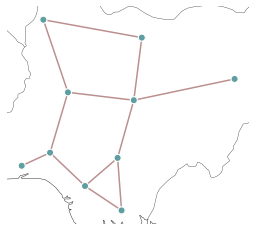

In [314]:
n.plot()

In [315]:
# temporal resolution - timesteps
len(n.snapshots)

2920

### Overview components

In [316]:
for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name, len(c.df)))

Component 'Bus' has 20 entries
Component 'Carrier' has 11 entries
Component 'GlobalConstraint' has 2 entries
Component 'Line' has 12 entries
Component 'LineType' has 31 entries
Component 'TransformerType' has 14 entries
Component 'Link' has 20 entries
Component 'Load' has 10 entries
Component 'Generator' has 34 entries
Component 'Store' has 10 entries


### Energy balance

In [317]:
n.stores_t.p.sum()

name
NG 0 battery    4.023406e-21
NG 1 battery   -4.764560e-21
NG 2 battery   -2.964615e-21
NG 3 battery   -1.164670e-21
NG 4 battery    3.176374e-22
NG 5 battery   -2.117582e-22
NG 6 battery   -1.270549e-21
NG 7 battery    1.270549e-21
NG 8 battery    6.988022e-21
NG 9 battery    6.670384e-21
dtype: float64

In [318]:
# Difference between total load and generation
# losses = n.stores_t
n.generators_t.p.sum().sum() - n.loads_t.p.sum().sum()  # - substract storage losses

0.0021659284830093384

### Total installed generator capacity

In [319]:
gen_cap = n.generators.groupby(["carrier"]).p_nom_opt.sum()
gen_cap

carrier
OCGT       8059.878073
oil        2737.667674
onwind        0.000006
ror           0.026105
solar     11590.882252
Name: p_nom_opt, dtype: float64

In [320]:
n.stores_t.p

name,NG 0 battery,NG 1 battery,NG 2 battery,NG 3 battery,NG 4 battery,NG 5 battery,NG 6 battery,NG 7 battery,NG 8 battery,NG 9 battery
snapshot,,,,,,,,,,
2013-01-01 00:00:00,7.513996e-08,7.581362e-08,7.681448e-08,1.042424e-07,7.680886e-08,9.110133e-08,7.526218e-08,7.620852e-08,7.478327e-08,9.831300e-08
2013-01-01 03:00:00,1.387195e-07,1.392636e-07,1.389716e-07,1.711551e-07,1.389625e-07,1.577390e-07,1.383195e-07,1.386924e-07,1.380235e-07,1.711954e-07
2013-01-01 06:00:00,4.182788e-07,4.184375e-07,4.180857e-07,4.825502e-07,4.182935e-07,4.551788e-07,4.184248e-07,4.184614e-07,4.188638e-07,4.782193e-07
2013-01-01 09:00:00,-6.323504e-07,-6.331992e-07,-6.315549e-07,-7.561366e-07,-6.324946e-07,-7.011063e-07,-6.315551e-07,-6.317262e-07,-6.320328e-07,-7.368389e-07
2013-01-01 12:00:00,-6.303026e-07,-6.299816e-07,-6.307209e-07,-7.560361e-07,-6.301125e-07,-7.011337e-07,-6.290688e-07,-6.305825e-07,-6.296985e-07,-7.424810e-07
...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,-6.372975e-07,-6.365159e-07,-6.374996e-07,-7.648146e-07,-6.367632e-07,-7.071069e-07,-6.365466e-07,-6.374687e-07,-6.367662e-07,-7.448249e-07
2013-12-31 12:00:00,-6.265454e-07,-6.275174e-07,-6.253398e-07,-7.495734e-07,-6.264814e-07,-6.970504e-07,-6.254402e-07,-6.254817e-07,-6.265869e-07,-7.338840e-07
2013-12-31 15:00:00,4.127117e-07,4.118278e-07,4.106857e-07,4.828017e-07,4.116232e-07,4.480271e-07,4.118746e-07,4.110332e-07,4.135680e-07,4.695857e-07


<AxesSubplot:xlabel='snapshot'>

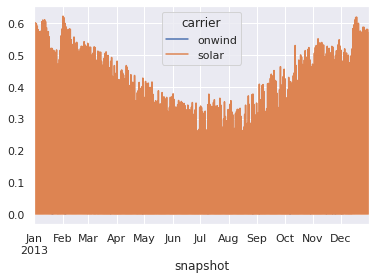

In [321]:
n.generators_t.p_max_pu.groupby(n.generators.carrier, axis=1).mean().plot()

In [322]:
# If 0, all renewable capacity potential is used
n.generators.p_nom_max.sum() - n.generators.p_nom_opt.sum()

inf

In [323]:
n.loads_t.p.sum().sum()

15481098.063516676

In [324]:
n.generators_t.p.sum().sum()

15481098.065682605

In [325]:
n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom_opt.sum() * 0.0000003

bus   carrier
NG 0  OCGT       3.717756e-05
      oil        4.354088e-05
      onwind     1.708115e-13
      ror        7.831624e-09
      solar      7.216899e-13
NG 1  OCGT       8.864978e-04
      oil        2.753089e-05
      onwind     1.424937e-13
      solar      4.009035e-13
NG 2  OCGT       5.806022e-04
      oil        4.595225e-04
      onwind     1.760367e-13
      solar      6.915347e-13
NG 3  oil        9.195408e-06
      onwind     2.171172e-13
      solar      1.079961e-03
NG 4  OCGT       6.030744e-04
      oil        2.580184e-04
      onwind     1.513028e-13
      solar      4.307827e-13
NG 5  oil        4.561502e-06
      onwind     2.367857e-13
      solar      8.907060e-04
NG 6  onwind     1.616230e-13
      solar      9.168333e-04
NG 7  OCGT       3.106114e-04
      oil        9.050599e-07
      onwind     1.644523e-13
      solar      6.217509e-13
NG 8  oil        1.802569e-05
      onwind     1.894777e-13
      solar      1.190277e-11
NG 9  onwind     1.995210e

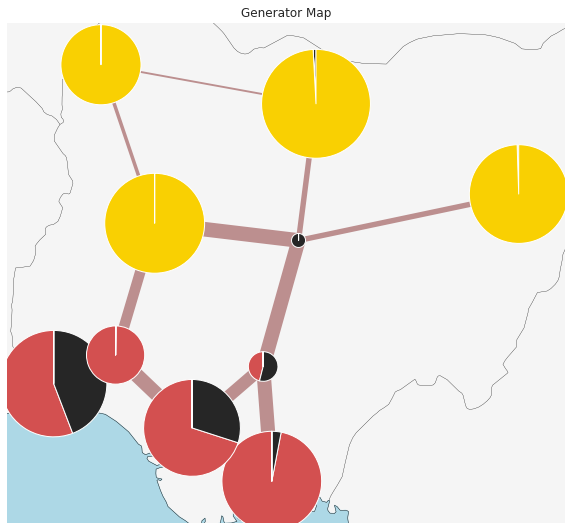

In [326]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

# loading = (n3.lines_t.p0.abs().mean().sort_index() / (n3.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom_opt.sum()
    ),
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="Generator Map",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off");

### Demand

In [327]:
type(n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum())

pandas.core.series.Series

<AxesSubplot:xlabel='snapshot'>

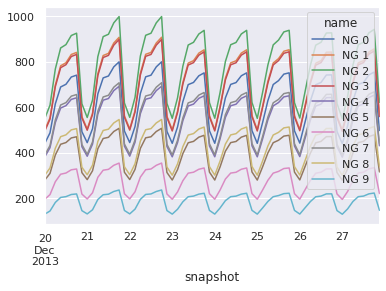

In [328]:
n.loads_t.p.loc["2013-12-20":"2013-12-27"].plot()

In [329]:
type(n.loads_t.p_set.sum())

pandas.core.series.Series

In [330]:
a = n.loads_t.p_set.sum().rename("load").rename_axis("bus")
a.rename("load", inplace=True)
a.rename_axis("bus", inplace=True)
a

bus
NG 0    1.861760e+06
NG 1    2.112923e+06
NG 2    2.324767e+06
NG 3    2.090515e+06
NG 4    1.612040e+06
NG 5    1.181932e+06
NG 6    8.263527e+05
NG 7    1.647936e+06
NG 8    1.271902e+06
NG 9    5.509693e+05
Name: load, dtype: float64

In [331]:
n.loads_t.p_set.sum().rename("load").rename_axis("bus")

bus
NG 0    1.861760e+06
NG 1    2.112923e+06
NG 2    2.324767e+06
NG 3    2.090515e+06
NG 4    1.612040e+06
NG 5    1.181932e+06
NG 6    8.263527e+05
NG 7    1.647936e+06
NG 8    1.271902e+06
NG 9    5.509693e+05
Name: load, dtype: float64

In [332]:
n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum()

bus
NG 0     269.087565
NG 1    3046.762333
NG 2    3467.082437
NG 3    3630.521204
NG 4    2870.309226
NG 5    2984.225157
NG 6    3056.111096
NG 7    1038.388302
NG 8      60.085673
NG 9    1965.881115
Name: p_nom_opt, dtype: float64

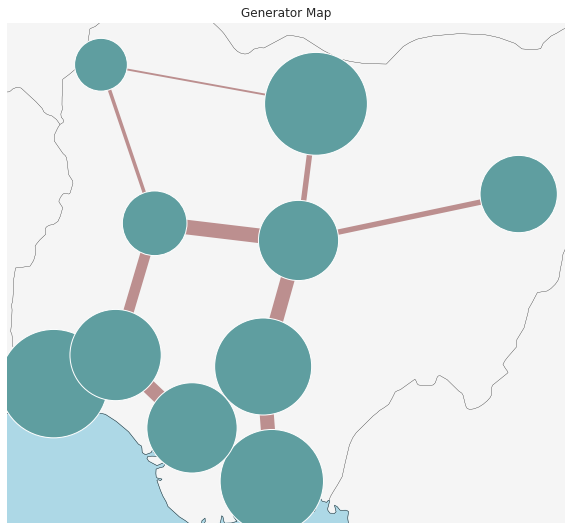

In [333]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

# loading = (n3.lines_t.p0.abs().mean().sort_index() / (n3.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        n.loads_t.p_set.sum().rename("load").rename_axis("bus")
    ),  # n.loads_t.p_set.sum().rename("load").rename_axis("bus")*.0000003,
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="Generator Map",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off");

In [334]:
# backup
gen_serie = n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom_opt.sum()
load_serie = n.loads_t.p_set.sum().rename("load").rename_axis("bus")

load_serie = pd.Series(
    load_serie.values,
    index=pd.MultiIndex.from_tuples([(id, "AC load") for id in load_serie.index]),
)

tot_serie = pd.concat([gen_serie, load_serie])  # .groupby(['bus', 'carrier']).sum()

pd.concat([gen_serie, load_serie])

bus   carrier
NG 0  OCGT       1.239252e+02
      oil        1.451363e+02
      onwind     5.693717e-07
      ror        2.610541e-02
      solar      2.405633e-06
NG 1  OCGT       2.954993e+03
      oil        9.176962e+01
      onwind     4.749789e-07
      solar      1.336345e-06
NG 2  OCGT       1.935341e+03
      oil        1.531742e+03
      onwind     5.867889e-07
      solar      2.305116e-06
NG 3  oil        3.065136e+01
      onwind     7.237239e-07
      solar      3.599870e+03
NG 4  OCGT       2.010248e+03
      oil        8.600612e+02
      onwind     5.043427e-07
      solar      1.435942e-06
NG 5  oil        1.520501e+01
      onwind     7.892855e-07
      solar      2.969020e+03
NG 6  onwind     5.387433e-07
      solar      3.056111e+03
NG 7  OCGT       1.035371e+03
      oil        3.016866e+00
      onwind     5.481743e-07
      solar      2.072503e-06
NG 8  oil        6.008563e+01
      onwind     6.315925e-07
      solar      3.967590e-05
NG 9  onwind     6.650698e

### Plot of Average Marginal Price

/tmp/ipykernel_21632/1424944530.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar()


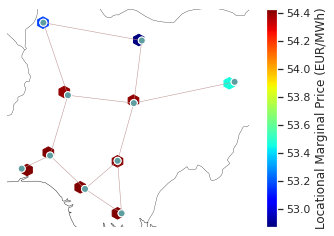

In [335]:
now = n.snapshots[4]  ##one specific time

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(6, 4)

n.plot(ax=ax, line_widths=pd.Series(0.5, n.lines.index))
plt.hexbin(
    n.buses.x,
    n.buses.y,
    gridsize=20,
    # C=n.buses_t.marginal_price.loc[now], #at one time (previous set up by scigrid)
    C=n.buses_t.marginal_price.sum()
    / len(n.snapshots[:]),  # Marginal price averaged over the whole year (My version)
    # - shows in which regions electricity will be cheap and where el. intensive companies should be placed.
    cmap=plt.cm.jet,
)

# for some reason the colorbar only works with graphs plt.plot
# and must be attached plt.colorbar

cb = plt.colorbar()
cb.set_label("Locational Marginal Price (EUR/MWh)")

### Storage

<AxesSubplot:xlabel='snapshot'>

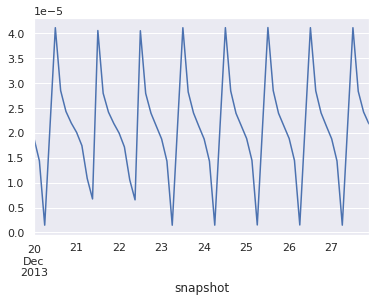

In [336]:
n.stores_t.e.loc["2013-12-20":"2013-12-27"].sum(axis=1).plot()

In [337]:
n.links.iloc[:].groupby(["carrier"]).p_nom_opt.sum()

carrier
battery charger       0.000016
battery discharger    0.000018
Name: p_nom_opt, dtype: float64